


**App :** The name of the app

**Category :** The category of the app

**Rating :** The rating of the app in the Play Store

**Reviews :** The number of reviews of the app

**Size :** The size of the app

**Install :** The number of installs of the app

**Type :** The type of the app (Free/Paid)

**Price :** The price of the app (0 if it is Free)

**Content Rating :** The appropiate target audience of the app

**Genres:** The genre of the app

**Last Updated :** The date when the app was last updated

**Current Ver :** The current version of the app

**Android Ver :** The minimum Android version required to run the app

In [1]:
# Data
import numpy as np
import pandas as pd
from collections import defaultdict

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msn
from wordcloud import WordCloud

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

# Hide warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("/Users/jackdaw/code/Data_preparation/cleaning/googleplaystore.csv")
df=df.drop(df.index[10472])

In [3]:
df['Installs'] = df['Installs'].str.replace('+', '').str.replace(',', '').astype(int)

In [4]:
df['Price'] = df['Price'].str.replace('$', '').astype(float)

In [5]:
def convert_size(size):
    if 'M' in size:
        return float(size.replace('M', '')) * 1024  # 将M转换为千字节
    elif 'k' in size:
        return float(size.replace('k', ''))  
    elif 'Varies with device' in size:
        return None  
    else:
        return None  

df['Size'] = df['Size'].apply(convert_size)

In [6]:
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# 对于数值型特征
df['Size'].fillna(df['Size'].median(), inplace=True)

# 对于类别型特征
# 假设 'Type' 是一个类别型特征，我们用最频繁的类别填充它的缺失值
df['Type'].fillna(df['Type'].mode()[0], inplace=True)

# 对 'Category' 进行独热编码
df = pd.get_dummies(df, columns=['Category'])

df.head()

,App,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,...,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19456.0,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",...,False,False,False,False,False,False,False,False,False,False
1,Coloring book moana,3.9,967,14336.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",...,False,False,False,False,False,False,False,False,False,False
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",4.7,87510,8908.8,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",...,False,False,False,False,False,False,False,False,False,False
3,Sketch - Draw & Paint,4.5,215644,25600.0,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",...,False,False,False,False,False,False,False,False,False,False
4,Pixel Draw - Number Art Coloring Book,4.3,967,2867.2,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",...,False,False,False,False,False,False,False,False,False,False


In [7]:
df.dropna(subset=['Rating'], inplace=True)

df.drop(['App', 'Type', 'Genres', 'Content Rating','Last Updated','Current Ver','Android Ver'], axis=1, inplace=True)
df.dtypes

Rating                          float64
Reviews                           int64
Size                            float64
Installs                          int64
Price                           float64
Category_ART_AND_DESIGN            bool
Category_AUTO_AND_VEHICLES         bool
Category_BEAUTY                    bool
Category_BOOKS_AND_REFERENCE       bool
Category_BUSINESS                  bool
Category_COMICS                    bool
Category_COMMUNICATION             bool
Category_DATING                    bool
Category_EDUCATION                 bool
Category_ENTERTAINMENT             bool
Category_EVENTS                    bool
Category_FAMILY                    bool
Category_FINANCE                   bool
Category_FOOD_AND_DRINK            bool
Category_GAME                      bool
Category_HEALTH_AND_FITNESS        bool
Category_HOUSE_AND_HOME            bool
Category_LIBRARIES_AND_DEMO        bool
Category_LIFESTYLE                 bool
Category_MAPS_AND_NAVIGATION       bool


In [8]:
df.dtypes

Rating                          float64
Reviews                           int64
Size                            float64
Installs                          int64
Price                           float64
Category_ART_AND_DESIGN            bool
Category_AUTO_AND_VEHICLES         bool
Category_BEAUTY                    bool
Category_BOOKS_AND_REFERENCE       bool
Category_BUSINESS                  bool
Category_COMICS                    bool
Category_COMMUNICATION             bool
Category_DATING                    bool
Category_EDUCATION                 bool
Category_ENTERTAINMENT             bool
Category_EVENTS                    bool
Category_FAMILY                    bool
Category_FINANCE                   bool
Category_FOOD_AND_DRINK            bool
Category_GAME                      bool
Category_HEALTH_AND_FITNESS        bool
Category_HOUSE_AND_HOME            bool
Category_LIBRARIES_AND_DEMO        bool
Category_LIFESTYLE                 bool
Category_MAPS_AND_NAVIGATION       bool


In [9]:
from src.corruptions.generic import InjectMissingValues
from src.corruptions.SwapValues import SwapColumnValues
from src.corruptions.gaussian_noise import GaussianNoise, Scaling

def inject_errors_to_multiple_columns(df):
    # Apply Gaussian noise to multiple numerical columns
    for column in ['Rating','Size','Price']:
        gaussian_noise = GaussianNoise(column=column, fraction=0.3)  # Increased fraction for a more pronounced effect
        df = gaussian_noise.transform(df)

    # Scale 'english_score' and 'geography_score'
    for column in ['Reviews', 'Installs','Price']:
        scaling = Scaling(column=column, fraction=0.3)
        df = scaling.transform(df)

    # Inject missing values into 'weekly_self_study_hours' and a categorical column
   # for column in ['Installs','Price']:
      #  inject_missing_values = InjectMissingValues(column=column, fraction=0.1)
      #  df = inject_missing_values.transform(df)

    return df
df = inject_errors_to_multiple_columns(df).copy()


In [10]:
X = df.drop('Rating', axis=1)  
y = df['Rating']            

# 划分数据集为训练集和测试集，这里使用20%的数据作为测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
models = ['Linear', 'KNN', 'Random Forest']
datasets = ['train', 'test']
metrics = ['RMSE', 'MAE', 'R2']

multi_index = pd.MultiIndex.from_product([models, datasets, metrics],
                                         names=['model', 'dataset', 'metric'])

df_metrics_reg = pd.DataFrame(index=multi_index,
                          columns=['value'])

In [12]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

df_metrics_reg.loc['Linear', 'train', 'R2'] = lr.score(X_train, y_train)
df_metrics_reg.loc['Linear', 'test', 'R2'] = lr.score(X_test, y_test)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

df_metrics_reg.loc['Linear', 'train', 'MAE'] = mean_absolute_error(y_train, y_train_pred)
df_metrics_reg.loc['Linear', 'test', 'MAE'] = mean_absolute_error(y_test, y_test_pred)

df_metrics_reg.loc['Linear', 'train', 'RMSE'] = mean_squared_error(y_train, y_train_pred, squared=False)
df_metrics_reg.loc['Linear', 'test', 'RMSE'] = mean_squared_error(y_test, y_test_pred, squared=False)

In [13]:
# KNN
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

df_metrics_reg.loc['KNN', 'train', 'MAE'] = mean_absolute_error(y_train, y_train_pred)
df_metrics_reg.loc['KNN', 'test', 'MAE'] = mean_absolute_error(y_test, y_test_pred)

df_metrics_reg.loc['KNN', 'train', 'RMSE'] = mean_squared_error(y_train, y_train_pred, squared=False)
df_metrics_reg.loc['KNN', 'test', 'RMSE'] = mean_squared_error(y_test, y_test_pred, squared=False)

In [14]:
# Random Forest
rf = RandomForestRegressor(max_depth=2, random_state=0)
rf.fit(X_train, y_train)

df_metrics_reg.loc['Random Forest', 'train', 'R2'] = rf.score(X_train, y_train)
df_metrics_reg.loc['Random Forest', 'test', 'R2'] = rf.score(X_test, y_test)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

df_metrics_reg.loc['Random Forest', 'train', 'MAE'] = mean_absolute_error(y_train, y_train_pred)
df_metrics_reg.loc['Random Forest', 'test', 'MAE'] = mean_absolute_error(y_test, y_test_pred)

df_metrics_reg.loc['Random Forest', 'train', 'RMSE'] = mean_squared_error(y_train, y_train_pred, squared=False)
df_metrics_reg.loc['Random Forest', 'test', 'RMSE'] = mean_squared_error(y_test, y_test_pred, squared=False)

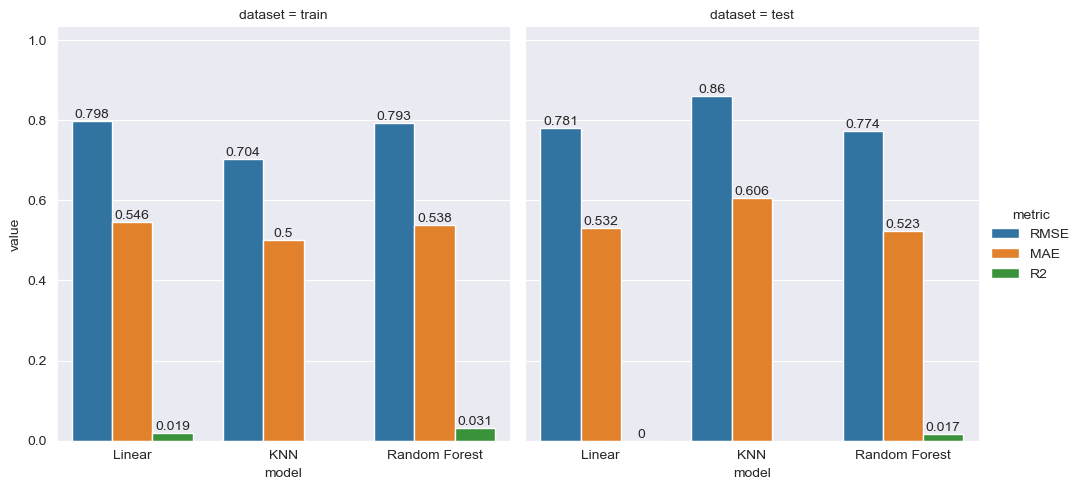

In [15]:
# Evaluation
df_metrics_reg['value'] = df_metrics_reg['value'].apply(lambda v: round(v, ndigits=3))
df_metrics_reg

data = df_metrics_reg.reset_index()

g = sns.catplot(col='dataset', data=data, kind='bar', x='model', y='value', hue='metric')

# Adding annotations to bars
# iterate through axes
for ax in g.axes.ravel():
    # add annotations
    for c in ax.containers:
        ax.bar_label(c, label_type='edge')

    ax.margins(y=0.2)

plt.show()